<a href="https://colab.research.google.com/github/LucasHenrique-dev/estudos-ia/blob/main/projetos/PSO/estudo_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar Bibliotecas

In [1]:
!pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


# Imports

In [2]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import sys

# Definir Locais

In [95]:
pontos = []
numero_locais = 5
local_inicio = 0
d_min = 0
d_max = 100

def criar_locais(numero_locais, d_min, d_max):
  for i in range(numero_locais):
    pos_x, pos_y = random.randint(d_min, d_max), random.randint(d_min, d_max)
    pontos.append((pos_x, pos_y))

In [96]:
criar_locais(numero_locais, d_min, d_max)
print(pontos)

[(60, 47), (37, 8), (30, 10), (37, 78), (43, 65)]


## Definir Distancias

In [97]:
def distancia_manhattam(p1, p2):
  return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

In [98]:
distancias = [[0 for i in range(numero_locais)] for j in range(numero_locais)]

for i in range(0, len(pontos)):
  for j in range(0, len(pontos)):
    distancias[i][j] = distancia_manhattam(pontos[i], pontos[j])

In [99]:
print(distancias)

[[0, 62, 67, 54, 35], [62, 0, 9, 70, 63], [67, 9, 0, 75, 68], [54, 70, 75, 0, 19], [35, 63, 68, 19, 0]]


# Abordagem PSO

## Função Fitness

In [100]:
def fitness_tsp(position):
  fitnessVal = 0
  cont = 0

  while cont <= len(position) - 2:
    fitnessVal += distancias[position[cont]][position[cont+1]]
    cont += 1

  return fitnessVal

## Definir Particula

In [101]:
class Particula:
  def __init__(self, fitness, dimensao, mm_size, inicio):

    # Criar lista com opções de posição
    posicoes = [i for i in range(dimensao) if i != inicio]

    # Iniciar todas as componentes de posição iniciais como zero
    self.posicao = [0 for i in range(dimensao+1)]

    # Iniciar todas as componentes de velocidade iniciais como zero
    self.velocidade = [(0, 0) for i in range(mm_size)]

    # Iniciar todas as componentes da melhor posição da partícula como zero
    self.best_part_pos = [0 for i in range(dimensao+1)]

    # Definir os valores de posição da partícula
    auxiliar = copy.copy(posicoes)
    for i in range(dimensao-1):
      index = random.randint(0, len(auxiliar)-1)
      self.posicao[i+1] = auxiliar.pop(index)
    
    # Definir os valores de velocidade da partícula
    for i in range(mm_size):
      self.velocidade[i] = (posicoes[random.randint(0, len(posicoes)-1)],
                              posicoes[random.randint(0, len(posicoes)-1)])
    
    # Definir as posições inicial e final como "inicio"
    self.posicao[0] = self.posicao[dimensao] = inicio
    
    # Calcular o valor de fitness da partícula
    self.fitness = fitness(self.posicao)

    # Definir os valores de melhor posição e fitness da partícula
    self.best_part_pos = copy.copy(self.posicao)
    self.best_part_fitness = self.fitness
  
  # Métodos auxiliares
  def swap(self, array, index1, index2):
    auxiliar = array[index1]
    array[index1] = array[index2]
    array[index2] = auxiliar

    return array
  
  def sum(self, mm1, mm2):
    return mm1 + mm2
  
  def mult(self, probabilidade, mm):
    mult_mm = []

    for i in range(len(mm)):
      rand = random.random()

      if rand <= probabilidade:
        mult_mm.append(mm[i])
    
    return mult_mm
  
  def sub(self, array1, array2): # C - D = MM -> C = D + MM | [1, 2, 3] - [3, 2, 1] = (0, 2)
    sub_mm = []
    auxiliar = copy.copy(array2)

    for index, value in enumerate(auxiliar):
      array1_index = array1.index(value)

      if index != array1_index:
        sub_mm.append((index, array1_index))
        auxiliar = self.swap(auxiliar, index, array1_index)

    return sub_mm

  def update_position(self, array, mm):
    new_position = copy.copy(array)

    for mo in mm:
      new_position = self.swap(new_position, mo[0], mo[1])

    return new_position

## Algoritmo PSO

In [102]:
def pso(fitness, max_iter, n, dim, inicio):
  # Hiperparâmetros
  mm_size = 2  # Tamanho da velocidade
  alfa = 0.85  # Coeficiente Cognitivo
  beta = 0.85  # Coeficiente Social

  # Iniciar o enxame
  enxame = [Particula(fitness, dim, mm_size, inicio) for i in range(n)]

  # Iniciar os valores de posição e fitness do enxame
  best_enxame_pos = [0 for i in range(dim)]
  best_enxame_fitness = sys.maxsize

  # Definir os melhores valores de posição e fitness do enxame
  for i in range(n):
    if enxame[i].fitness < best_enxame_fitness:
      best_enxame_fitness = enxame[i].fitness
      best_enxame_pos = copy.copy(enxame[i].posicao)
  
  # Realizar as "max_iter" buscas do enxame
  iter = 0
  while iter < max_iter:

    # Iteração para cada partícula
    for i in range(n):
      # Computar a nova velocidade das partículas

      # Velocidade_2 = velocidade_1 + alfa * (Pbest - X) + beta * (Gbest - X)
      sub_Pbest = enxame[i].sub(enxame[i].best_part_pos, enxame[i].posicao)
      sub_Gbest = enxame[i].sub(best_enxame_pos, enxame[i].posicao)
      mult_alfa = enxame[i].mult(alfa, sub_Pbest)
      mult_beta = enxame[i].mult(beta, sub_Gbest)
      sum_alfa = enxame[i].sum(enxame[i].velocidade, mult_alfa)

      enxame[i].velocidade = enxame[i].sum(sum_alfa, mult_beta)

      # Computar nova componente de posição
      enxame[i].posicao = enxame[i].update_position(enxame[i].posicao,
                                                      enxame[i].velocidade)
      
      # Computar novo valor de fitness
      enxame[i].fitness = fitness(enxame[i].posicao)

      # Verificar novo valor para best_part_fitness
      if enxame[i].fitness < enxame[i].best_part_fitness:
        enxame[i].fitness = enxame[i].best_part_fitness
        enxame[i].best_part_pos = copy.copy(enxame[i].posicao)
      
      # Verificar novo valor para best_enxame_fitness
      if enxame[i].fitness > best_enxame_fitness:
        best_enxame_fitness = enxame[i].fitness
        best_enxame_pos = copy.copy(enxame[i].posicao)
      
    iter += 1

    return best_enxame_pos

## Resolver Problema

In [103]:
fitness = fitness_tsp
max_iter = 500
n = 100
dim = numero_locais
inicio = local_inicio

solution_pso = pso(fitness, max_iter, n, dim, inicio)
custo_pso = fitness(solution_pso)

print(f'Objetivo: {custo_pso} miles\nRota: {(" -> ").join(str(num) for num in solution_pso)}')

Objetivo: 310 miles
Rota: 0 -> 4 -> 2 -> 3 -> 1 -> 0


# Abordagem Google OR-Tools

## Criar Dados

In [104]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distancias
    data['num_vehicles'] = 1
    data['depot'] = local_inicio
    return data

## Criar o Modelo de Roteamento

In [105]:
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

## Criar o Callback de Distância

In [106]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

## Definir Custo de Distância

In [107]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

## Definir Parâmetros de Pesquisa

In [108]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

## Salvar Solução

In [109]:
def get_routes(solution, routing, manager):
  """Get vehicle routes from a solution and store them in an array."""
  # Get vehicle routes and store them in a two dimensional array whose
  # i,j entry is the jth location visited by vehicle i along its route.
  routes = []
  for route_nbr in range(routing.vehicles()):
    index = routing.Start(route_nbr)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route)
  return routes

## Imprimir Solução

In [110]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)

## Resolver Problema

In [111]:
solution = routing.SolveWithParameters(search_parameters)
custo_Google_OR = solution.ObjectiveValue()
if solution:
  solution_Google_OR = get_routes(solution, routing, manager)
  print_solution(manager, routing, solution)

Objective: 200 miles
Route for vehicle 0:
 0 -> 4 -> 3 -> 1 -> 2 -> 0



# Exibir Soluções

## Exibir Cidades

In [112]:
def exibir_cidades(coordenadas, arestas, ponto_inicial):
    # Criar um array NumPy com as coordenadas
    pontos = np.array(coordenadas)

    # Criar uma figura com um subplot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plotar os pontos
    plt.scatter(pontos[:, 0], pontos[:, 1], color='red', label='Cidades')
    
    # Destacar o ponto inicial
    plt.scatter(pontos[ponto_inicial][0], pontos[ponto_inicial][1], color='green', label='Cidade Inicial')
    
    # Adicionar rótulos aos pontos
    for i, (x, y) in enumerate(pontos):
        plt.annotate(f'Cidade {i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plotar as linhas entre os pontos
    for i in range(len(arestas)):
        for j in range(len(arestas[i])):
            if i != j:
                plt.plot([pontos[i][0], pontos[j][0]], [pontos[i][1], pontos[j][1]], 'b--', alpha=0.6)
                plt.annotate(f'{arestas[i][j]} milhas', ((pontos[i][0] + pontos[j][0]) / 2, (pontos[i][1] + pontos[j][1]) / 2),
                             textcoords="offset points", xytext=(0, -10), ha='center', color='purple')
    
    # Configurar o título e legendas
    ax.set_title('Sistema de Cidades e Distâncias')
    ax.legend()
    plt.tight_layout()
    
    # Retornar a figura criada
    return fig

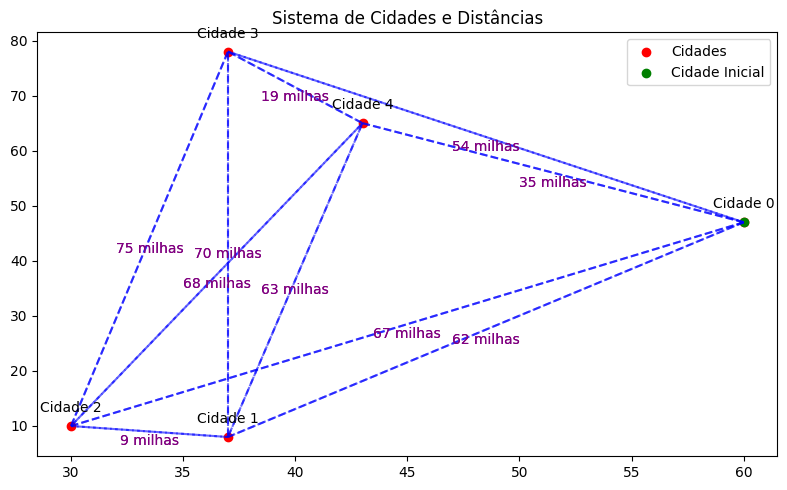

In [113]:
# Dados
coordenadas = pontos
arestas = distancias
ponto_inicial = local_inicio

# Chamar a função para obter o gráfico
grafico_1 = exibir_cidades(coordenadas, arestas, ponto_inicial)

# Exibir o gráfico
plt.show(grafico_1)

## Exibir Percurso

In [114]:
def exibir_percurso(coordenadas, arestas, percurso, ponto_inicial):
    # Criar um array NumPy com as coordenadas
    pontos = np.array(coordenadas)

    # Criar uma figura com um subplot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plotar os pontos
    plt.scatter(pontos[:, 0], pontos[:, 1], color='red', label='Cidades')

    # Destacar o ponto inicial
    plt.scatter(pontos[ponto_inicial][0], pontos[ponto_inicial][1], color='green', label='Cidade Inicial')
    
    # Adicionar rótulos aos pontos
    for i, (x, y) in enumerate(pontos):
        plt.annotate(f'Cidade {i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
    # Traçar a rota do percurso com linhas orientadas
    for i in range(len(percurso) - 1):
      ponto_atual = percurso[i]
      proximo_ponto = percurso[i + 1]
      plt.arrow(pontos[ponto_atual][0], pontos[ponto_atual][1], pontos[proximo_ponto][0] - pontos[ponto_atual][0],
                pontos[proximo_ponto][1] - pontos[ponto_atual][1], color='gray', length_includes_head=True,
                head_width=1, width=0.2)
      plt.annotate(f'{arestas[ponto_atual][proximo_ponto]} milhas',
                    ((pontos[ponto_atual][0] + pontos[proximo_ponto][0]) / 2,
                    (pontos[ponto_atual][1] + pontos[proximo_ponto][1]) / 2),
                    textcoords="offset points", xytext=(0, -10), ha='center', color='blue')

    # Configurar o título e legendas
    ax.set_title('Percurso com Distâncias')
    ax.legend()
    plt.tight_layout()
    
    # Retornar a figura criada
    return fig

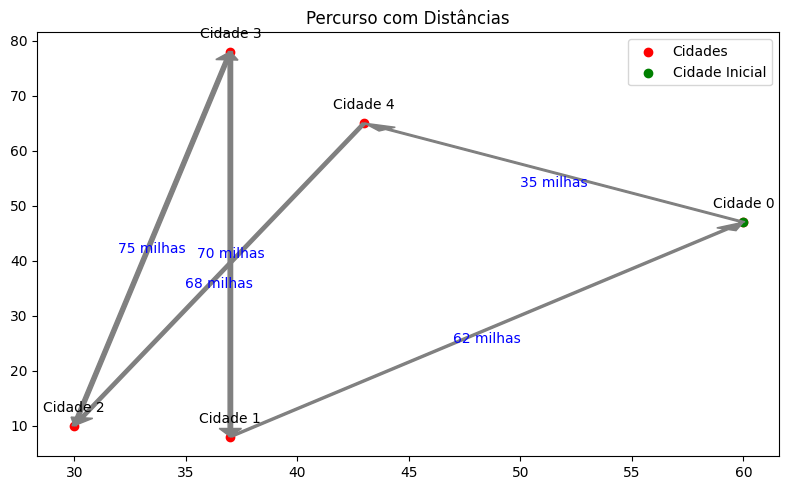


Custo: 310 milhas


In [115]:
# Dados
coordenadas = pontos
arestas = distancias
percurso = solution_pso
ponto_inicial = local_inicio

# Chamar a função para obter o gráfico
grafico_2 = exibir_percurso(coordenadas, arestas, percurso, ponto_inicial)

# Exibir o gráfico
plt.show(grafico_2)

# Exibir custo da solução
print(f'\nCusto: {custo_pso} milhas')

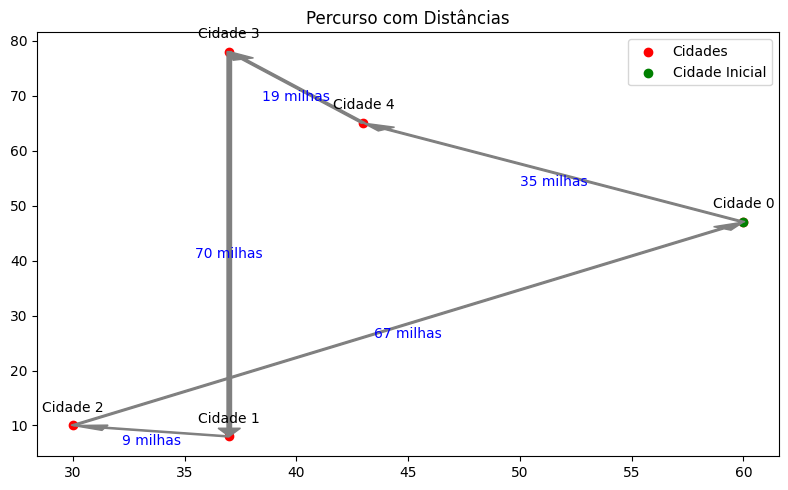


Custo: 200 milhas


In [116]:
# Dados
coordenadas = pontos
arestas = distancias
percurso = solution_Google_OR[0]
ponto_inicial = local_inicio

# Chamar a função para obter o gráfico
grafico_3 = exibir_percurso(coordenadas, arestas, percurso, ponto_inicial)

# Exibir o gráfico
plt.show(grafico_3)

# Exibir custo da solução
print(f'\nCusto: {custo_Google_OR} milhas')

## Comparar Soluções

In [117]:
# Função auxiliar para converter a figura em um array NumPy
def fig2data(fig):
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    return np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)

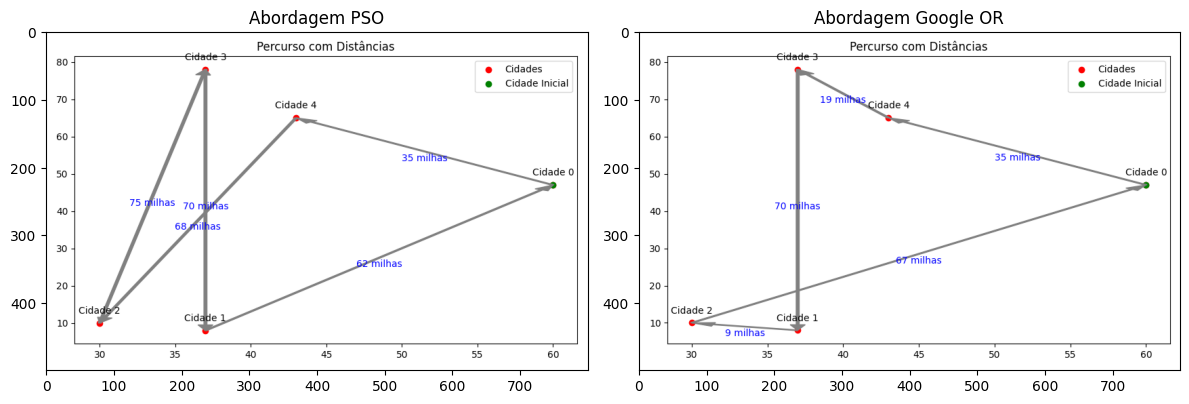

In [118]:
def comparar_graficos(grafico1, grafico2):
    # Criar uma figura com dois subplots lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Converter a figura em um array NumPy
    fig_array_1 = fig2data(grafico1)
    fig_array_2 = fig2data(grafico2)

    # Adicionar os gráficos aos subplots
    axs[0].imshow(fig_array_1)
    axs[1].imshow(fig_array_2)
    
    # Configurar o título dos subplots
    axs[0].set_title('Abordagem PSO')
    axs[1].set_title('Abordagem Google OR')
    
    # Configurar o layout da figura
    fig.tight_layout()
    
    # Exibir a figura com os subplots lado a lado
    plt.show()

# Exemplo de gráficos
grafico1 = grafico_2  # Seu primeiro gráfico
grafico2 = grafico_3  # Seu segundo gráfico

# Chamar a função para exibir os gráficos lado a lado
comparar_graficos(grafico1, grafico2)

## Exibir Gráficos

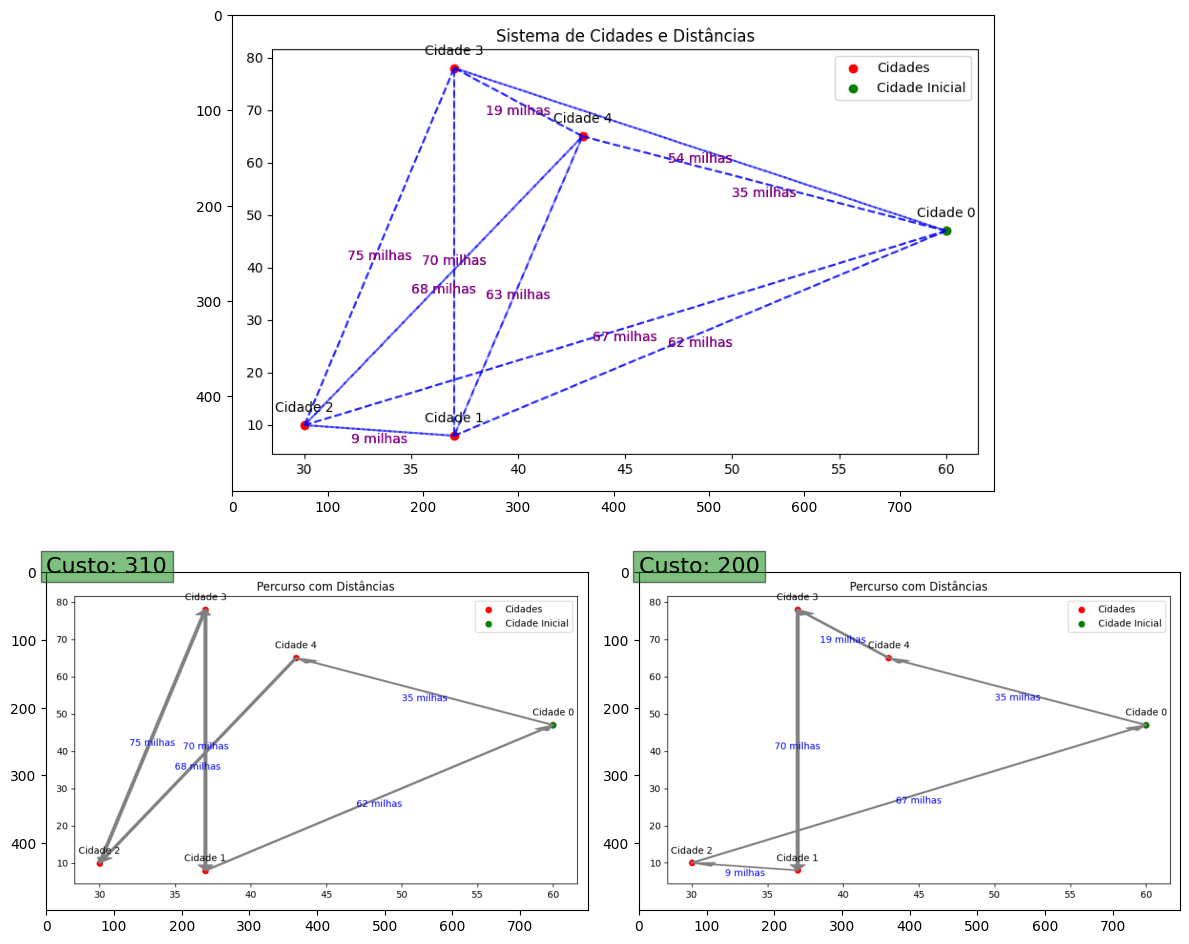

In [119]:
def exibir_estudo_completo(grafico1, grafico2, grafico3,
                            custo_solucao1=-1, custo_solucao2=-1):
    # Definir tamanho da imagem
    fig = plt.figure() 
    fig.set_figheight(10) 
    fig.set_figwidth(12)

    # Criar uma figura com subplots
    ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2) 
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1) 
    ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), colspan=1)

    # Converter a figura em um array NumPy
    fig_array_1 = fig2data(grafico1)
    fig_array_2 = fig2data(grafico2)
    fig_array_3 = fig2data(grafico3)
    
    # Adicionar os gráficos aos subplots
    ax1.imshow(fig_array_1)
    ax2.imshow(fig_array_2)
    ax3.imshow(fig_array_3)

    if custo_solucao1 != -1 and custo_solucao2 != -1:
      ax2.annotate(f'Custo: {custo_solucao1}', xy=(0, 0), fontsize=16,
                   xytext=(0, 0), bbox = dict(facecolor = 'green', alpha = 0.5))
      ax3.annotate(f'Custo: {custo_solucao2}', xy=(0, 0), fontsize=16,
                   xytext=(0, 0), bbox = dict(facecolor = 'green', alpha = 0.5))
    
    # Ajustar o espaçamento entre os subplots
    fig.tight_layout()
    
    # Exibir a figura com todos os subplots
    plt.show()

# Chamar a função para obter os gráficos
grafico1 = exibir_estudo_completo(grafico_1, grafico_2, grafico_3,
                                    custo_pso, custo_Google_OR)

# Referências

Google = https://developers.google.com/optimization/routing/vrp?hl=pt-br#create_the_data

PSO IN TSP ON MATLAB = https://github.com/arvin2079/PSO-on-TSP-in-matlab/blob/master/refs/paper.pdf

Tese Mestrado = https://tede.unioeste.br/bitstream/tede/4935/9/Luis_Henrique_Chouay_Dall_Agnese_2020.pdf

Slides = https://github.com/marcoscastro/tsp_pso/blob/master/references/slides.pdf